In [ ]:
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import History 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/Knowledge-Distillation")
os.listdir()

['MNIST_KD.ipynb',
 'CIFAR10_ResNet18.h5',
 'CIFAR10_Student_Model.h5',
 'alpha_temp.npy',
 'amount_data.npy',
 'models',
 'actions',
 'plot_utils',
 'CIFAR-10.ipynb',
 'studentcifar.png',
 '.ipynb_checkpoints',
 'SSgrid.png']

In [ ]:
import models.ResNet18 as ResNet18
import models.CIFAR10_Student_Model as CIFAR10_Student
import plot_utils.Plot_Heatmap
import plot_utils.Plot_Model
import actions.Classification_Distiller as Distiller

In [ ]:
def loadDataset():
  (trainX, trainy), (testX, testy) = cifar10.load_data()

  trainy = trainy
  testy  = testy
  
  train_norm = trainX.astype('float32')/255.0
  test_norm  = testX.astype('float32')/255.0

  return train_norm, trainy, test_norm, testy

In [ ]:
trainX, trainy, testX, testy = loadDataset()

170500096/170498071 [==============================] - 6s 0us/step


In [ ]:
def saveModel(inp_model, filename):
  inp_model.save(filename)
  return

def loadModel(filename):
  model = load_model(filename)
  return model

In [ ]:
from keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch, lr):
    if (epoch+1) % 30 == 0: new_lr = lr * 0.1
    else:                   new_lr = lr
    
    #print('lr: %.2e' % new_lr)
    return new_lr 

lr_callback = LearningRateScheduler(lr_scheduler)

In [ ]:
teacher = loadModel("CIFAR10_ResNet18.h5")
student = loadModel("CIFAR10_Student_Model.h5")

In [ ]:
import actions.Classification_Distiller as Distiller
from tensorflow.keras.losses import KLDivergence

## **Experiment 4: Teacher Free Knowledge Distillation**

In [ ]:
#hyperparameters for grid search
alpha_vals = [0.2, 0.4, 0.6, 0.8, 1.0]
temp_vals  = [2, 4, 6, 8, 10]

In [ ]:


res = []
for i in range(len(alpha_vals)):
  alpha = alpha_vals[i]
  res.append([])
  for j in range(len(temp_vals)):
    temp = temp_vals[j]
    curr_student_model = CIFAR10_Student.createStudentModel()
    distiller = Distiller.Distiller(student=curr_student_model, teacher=student)
    distiller.compile(
        optimizer=Adam(),
        metrics=[SparseCategoricalAccuracy()],
        student_loss_fn=SparseCategoricalCrossentropy(from_logits=True),
        distillation_loss_fn=KLDivergence(),
        alpha=alpha,
        temperature=temp,
    )

    distiller.fit(trainX, trainy, epochs=50, batch_size=32,callbacks=[lr_callback],verbose=0)
    curr_acc = distiller.evaluate(testX, testy)
    res[i].append(curr_acc)
    print("alpha = ", alpha, ", T = ", temp, ", accuracy = ", curr_acc)


313/313 [==============================] - 1s 2ms/step - sparse_categorical_accuracy: 0.8874 - loss: 0.4063
alpha =  0.2 , T =  2 , accuracy =  [0.8873999714851379, 0.4032479226589203]
313/313 [==============================] - 1s 3ms/step - sparse_categorical_accuracy: 0.8840 - loss: 0.4263
alpha =  0.2 , T =  4 , accuracy =  [0.8840000033378601, 0.42134183645248413]
313/313 [==============================] - 1s 2ms/step - sparse_categorical_accuracy: 0.8834 - loss: 0.4406
alpha =  0.2 , T =  6 , accuracy =  [0.883400022983551, 0.5011377334594727]
313/313 [==============================] - 1s 3ms/step - sparse_categorical_accuracy: 0.8822 - loss: 0.4360
alpha =  0.2 , T =  8 , accuracy =  [0.8822000026702881, 0.37874117493629456]
313/313 [==============================] - 1s 2ms/step - sparse_categorical_accuracy: 0.8763 - loss: 0.4489
alpha =  0.2 , T =  10 , accuracy =  [0.8762999773025513, 0.7622928619384766]
313/313 [==============================] - 1s 3ms/step - sparse_categoric

In [ ]:
import numpy as np
#Manually creating accuracy matrix from the results of grid search above
accuracy = np.array([[88.74,88.40,88.34,88.22,87.63],[88.58,88.61,87.87,87.38,87.49],[88.67,88.2,87.81,87.26,87.57],[88.61,87.93,87.47,86.80,87.20],[88.44,87.71,86.95,86.87,87.02]])
print(accuracy)

[[88.74 88.4  88.34 88.22 87.63]
 [88.58 88.61 87.87 87.38 87.49]
 [88.67 88.2  87.81 87.26 87.57]
 [88.61 87.93 87.47 86.8  87.2 ]
 [88.44 87.71 86.95 86.87 87.02]]


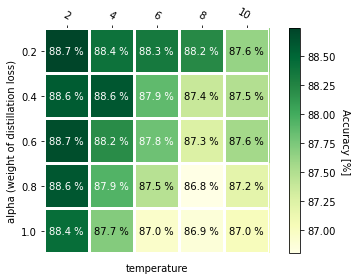

In [ ]:
fig, ax = plt.subplots()
im, cbar = plot_utils.Plot_Heatmap.heatmap(accuracy, alpha_vals, temp_vals, "temperature", "alpha (weight of distillation loss)", ax=ax, cmap="YlGn", cbarlabel="Accuracy [%]")
texts = plot_utils.Plot_Heatmap.annotate_heatmap(im, valfmt="{x:.1f} %")

fig.tight_layout()
plt.show()

## **Experiment 5: Distilled Student as Teacher**

In [ ]:
curr_student_model = CIFAR10_Student.createStudentModel()
distiller = Distiller.Distiller(student=curr_student_model, teacher=student)
distiller.compile(
    optimizer=Adam(),
    metrics=[SparseCategoricalAccuracy()],
    student_loss_fn=SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=KLDivergence(),
    alpha=0.6,
    temperature=2,
)

distiller.fit(trainX, trainy, epochs=50, batch_size=32,validation_data=(testX, testy),callbacks=[lr_callback],verbose=1)

Epoch 1/50
1563/1563 [==============================] - 18s 7ms/step - sparse_categorical_accuracy: 0.4101 - student_loss: 1.5994 - distillation_loss: 1.1153 - loss: 3.3164 - val_sparse_categorical_accuracy: 0.6258 - val_loss: 1.1326
Epoch 2/50
1563/1563 [==============================] - 11s 7ms/step - sparse_categorical_accuracy: 0.6589 - student_loss: 1.0759 - distillation_loss: 0.7048 - loss: 2.1218 - val_sparse_categorical_accuracy: 0.7205 - val_loss: 1.1027
Epoch 3/50
1563/1563 [==============================] - 10s 7ms/step - sparse_categorical_accuracy: 0.7182 - student_loss: 0.9212 - distillation_loss: 0.5770 - loss: 1.7533 - val_sparse_categorical_accuracy: 0.7430 - val_loss: 1.3853
Epoch 4/50
1563/1563 [==============================] - 10s 7ms/step - sparse_categorical_accuracy: 0.7560 - student_loss: 0.8149 - distillation_loss: 0.4969 - loss: 1.5185 - val_sparse_categorical_accuracy: 0.7891 - val_loss: 0.6352
Epoch 5/50
1563/1563 [==============================] - 11s 7ms/

The distilled student achieves an accuracy of 88.43% (88.51% after 45th epoch)

In [ ]:
curr_student_model.compile(optimizer=Adam(),
        metrics=[SparseCategoricalAccuracy()])

Training a student model using pre-trained distillled student model with 88.43% accuracy for different values of alpha and temperature

In [ ]:
alpha_vals = [0.2, 0.4, 0.6]
temp_vals  = [2,4]
for i in range(len(alpha_vals)):
  alpha = alpha_vals[i]
  for j in range(len(temp_vals)):
    temp = temp_vals[j]
    print("alpha = ", alpha, ", T = ", temp)
    curr_student_model_2 = CIFAR10_Student.createStudentModel()
    distiller = Distiller.Distiller(student=curr_student_model_2, teacher=curr_student_model)
    distiller.compile(
        optimizer=Adam(),
        metrics=[SparseCategoricalAccuracy()],
        student_loss_fn=SparseCategoricalCrossentropy(from_logits=True),
        distillation_loss_fn=KLDivergence(),
        alpha=alpha,
        temperature=temp,
    )

    distiller.fit(trainX, trainy, epochs=50, batch_size=32,validation_data=(testX, testy),callbacks=[lr_callback],verbose=1)

alpha =  0.2 , T =  2
Epoch 1/50
1563/1563 [==============================] - 12s 7ms/step - sparse_categorical_accuracy: 0.3907 - student_loss: 1.5671 - distillation_loss: 1.2296 - loss: 2.2374 - val_sparse_categorical_accuracy: 0.6284 - val_loss: 1.3492
Epoch 2/50
1563/1563 [==============================] - 10s 7ms/step - sparse_categorical_accuracy: 0.6291 - student_loss: 1.0334 - distillation_loss: 0.8065 - loss: 1.4719 - val_sparse_categorical_accuracy: 0.7077 - val_loss: 1.2992
Epoch 3/50
1563/1563 [==============================] - 10s 7ms/step - sparse_categorical_accuracy: 0.7034 - student_loss: 0.8721 - distillation_loss: 0.6462 - loss: 1.2146 - val_sparse_categorical_accuracy: 0.7582 - val_loss: 0.7950
Epoch 4/50
1563/1563 [==============================] - 11s 7ms/step - sparse_categorical_accuracy: 0.7445 - student_loss: 0.7642 - distillation_loss: 0.5447 - loss: 1.0471 - val_sparse_categorical_accuracy: 0.7868 - val_loss: 0.7334
Epoch 5/50
1563/1563 [====================

For alpha = 0.4 and temperature T = 4 the student model achieves an accuracy of 88.84% (**88.98%** after 47th epoch)

In [ ]:
curr_student_model_2.compile(optimizer=Adam(),
        metrics=[SparseCategoricalAccuracy()])